# 문장 기호 자동 추가
문장이 주어졌을 때 문장 부호인 마침표('.')와 쉼표(',') 를 자동으로 추가하는 프로그램을 작성하는 것을 목표로 한다.  
이를 수행하기 위하여 복수의 문장을 입력 받아 Deep Learning Network 을 구성하여 training 하고,  
주어진 문장에 대하여 적용하여 실제 동작을 잘 수행하는지 확인 한다  

예를 들면, 아래와 같이 문장이 주어졌다고 가정하자.  
```
   "오늘 걷지 않는다면 내일은 뛰어야 한다"
```
우리가 원하는 결과는 아래와 같을 것이다.  
```
   "오늘 걷지 않는다면, 내일은 뛰어야 한다."
```
  
## overview

입력된 문장에서 target 을 아래와 같이 구성한다  

```
 문자 : '<nop>'  
   . : '.'  
   , : ','  
```

즉, 위의 예를 다시 쓰면 아래처럼 될 것이다. 
```
   오 : '<nop>'
   늘 : '<nop>'
      : '<nop>'
   걷 : '<nop>'
   ... 
   면 : '<nop>'
   , : ','
     : '<nop>'
   내 : '<nop>'
   일 : '<nop>'
   ...
   한 : '<nop>'
   다 : '<nop>'
   . : '.'
```
```
"오늘 걷지 않는다면, 내일은 뛰어야 한다."
```
가 들어오면, 
```
<nop><nop><nop><nop><nop><nop><nop><nop><nop><nop>,<nop><nop><nop><nop><nop><nop>."
```
위와 같이 &lt;nop>, ',',  '.' 로 이루어진 리스트가 출력되는 문제로 추상화할 수 있다. 
즉, 각각의 character 하나마다, 3개의 class 중 하나의 값으로 분류하는 문제라고 볼 수 있다.  

문장의 형태소 정보라든지 추가적인 정보를 사용한다면, 더 좋은 결과를 얻을 수 있을 것이라고 추측되나,  
문제를 단순화 하기 위하여 문장을 문자 단위로 다루기로 한다.  

In [10]:
%load_ext autoreload


In [11]:
%autoreload 2

In [5]:
!pip install termcolor

  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/de/f7/bf/1bcac7bf30549e6a4957382e2ecab04c88e513117207067b03
Successfully built termcolor


In [13]:
import tensorflow as tf

print(tf.__version__)

1.3.0


## preprocessing 

입력은 한글로 된 세종 코퍼스 중 텍스트를 미리 다운 받아 처리하였다.  
입력된 data 에서 $lt;body> 중 $lt;p> $lt;/p> 로 묶인 문장만을 사용하였다. 
  
우선 trainging 을 위하여 입력한 data의 전처리가 필요하다.  
문장을 입력받으면, 이에 대응하는 character vector 를 구성하여, input에 대한 dictionary 를 구성한다. 
한글의 문자는 그 수가 많고, 입력된 텍스트에는 영어나 특수 문자 등이 포함되었을 수 있으니,  
모든 문자를 dictionary에 추가할 수는 없다.  
그러므로 입력 문자의 빈도수를 보고 적절한 갯수로 입력 dictionary 의 크기를 제한한다. 
  
아래는 입력된 문자에 대한 빈도수를 log scale 로 보여주는 그래프이다.  
이 그래프를 참고하여 임의의 갯수로 dictionary 이 크기를 제한하여 진행하였다. 

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


length of paragraph:  1104  characters:  190957


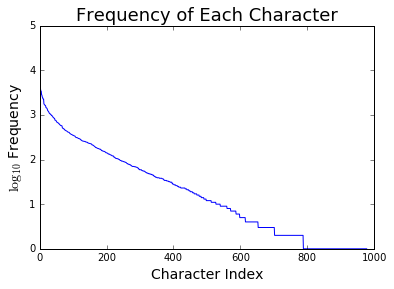

In [6]:
import math, numpy as np, matplotlib.pyplot as plt
import data

rawdata = data.read_data("data/training/4BH00005.txt")

sorted_char_map = data.get_sorted_char_map(rawdata)

plt.title('Frequency of Each Character', fontsize=18)
plt.plot(np.array([math.log10(k[1]) for k in sorted_char_map]))
plt.ylabel('$\log_{10}$ Frequency', fontsize=14)
plt.xlabel('Character Index', fontsize=14)
plt.show()

## 네트워크 구성 

입력은 임의로 정한 dictionary 중 하나이고,  
이러한 입력이 들어올 때  
출력은 세 개의 케이스 ('&lt;nop>', '.', ',') 중 하나를 출력하도록 하는 네트워크를 구성한다.  
출력의 값이 존재하는 문제로 정의하였으므로,  
supervised learning 으로 문제를 해결한다.  
  
문장을 training하여 문장 부호를 예측하는 모델에서  
각 문장의 character 들은 그 이전에 나온 character와 밀접한 관계를 가지므로 
이전 output 이 다음 step 의 input 으로 사용하는 네트워크인 Recurrent Neural Network 을 사용한다.  

RNN 의 cell은 vanishing gradient 의 영향을 줄일 수 있는 LSTM 을 사용한다.  
RNN 의 구성은 아래의 두 케이스를 진행하였다.  

### Multilayer RNN 
Layer 를 2 layer를 사용하였고, hidden size 는 128 로 설정하였다.  
각 cell 은 이전 cell 의 output 을 LSTM 의 input 으로 사용한다. 
100 개중 1 * 128 * 128 * 3 개중 1의 네트워크가 될 것이다. 
[그림]





### Bidirectional RNN 
테스트를 수행한 결과를 살펴보니, '.' 을 예측하는 과정에서, 
만약 아래와 같은 문장이 있을 때, 
```
"그가 방에 들어간다면" 
```
아래처럼 예측하는 경우를 볼 수 있었다. 
```
"그가 방에 들어간다.면" 
```
  
앞의 문자들만을 고려하고 있어서 발생하는 현상이라고 판단되어, 
forward와 backward 를 모두 고려하는 Bidirectional RNN 을  
사용하는 것이 정확도를 더 올릴 수 있을 것이라고 생각되어 이를 추가하였다.  
Multilayer RNN에서도 두개의 cell 만을 사용하였으므로,  
비교를 위해 Bidirectional 도 forward, backward 두 개의 cell 만을 사용하였다.

### 수행 결과 측정
수행 결과를 측정한 지표로는 아래를 사용하였다. 
- loss 
training 시 결과로 리턴되는 값으로,  실측 data(target data)와 prediction 결과와의 차이를 나타낸다. 
- accuracy
실측 data 와 prediction 의 결과로 각각 나온 list 를 비교하여 각 item 별로 비교하여,  
같으면 true, 다르면 false 로 하여 이를 평균낸 값이다.  
- speed 
수행 시간을 나타낸다.  
- precision, recall, f-score
전통적으로 NLP, 검색엔진 등의 성능을 측정하는 지표로 알려진 precision, recall, f-score 를 사용한다.  
    - precision
    prediction 한 결과 값 중 실제 data 와 일치하는 비율
    - recall
    실측 data 중 몇개가 prediction 과 일치하는지에 대한 비율
    - f-score
    precision 과 recall 을 하나의 지표로 표시하기 위한 목적으로 두 값의 조화평균


    
    

마침표의 경우 뚜렷한 패턴이 있으므로, 짧은 트레이닝 주기에서도 상당히 높은 예측률을 얻을 수 있었다. 
하지만 쉼표의 경우는 예측율이 낮았다. 
한국어에서 쉼표가 다양한 패턴으로 사용되고, 특히 명사의 나열과 같은 (ex> 사과, 포도, 배 등) 경우의 사용에서는 
품사 정보가 있지 않다면, 예측을 하기 어려울 것으로 보인다. 


## Implementation 
### data preprocessing  과정 
아래는 실제 data file 을 read 하여  
character 에 대한 dictionary 를 구성하는 부분이다.  
입력 dictionary 로는 100 개로 설정하였고, 출력은 '&lt;nop>, '.', ',' 3개 중 하나가 된다.   
입력한 data 는 편의를 위하여 고정된 길이의 sequence length 로 나누어 저장한다.  
이 sequence length 는 RNN 에서 몇개의 data 까지 고려할지를 결정하는 step 갯수의 값이 될 것이다.  
각각 나눈 data 는 아래와 같은 종류로 전처리하여 저장한다. 
    - input data 
    고정길이로 나눈 문장에서 '.'과 ','를 삭제한 후 미리 구성한 dictionary 의 index 로 치환한다. 
    - target data 
    입력된 문장에 대한 실제 결과로, 입력된 문장을 '&lt;nop>', '.', ',' 로 변경한 결과를 저장한다.  
    - sequence length 
    입력된 text 를 고정길이로 나누어 사용하여 필요가 없으나, 입력 문장에서 '.', ',' 를 strip 하는 과정을 거친 결과로,  
    문장의 길이에 차이가 발생한다.  
    이에 대응하기 위하여 input data 를 strip 한 길이를 저장하는 벡터가 필요하다.  
    
training 에 사용된 data 의 10프로는 overfitting을 방지하기 위하여 검증에 사용하도록,  
preprocessing 한 dataset 을 training 용도와 validation 용도로 나누어 저장한다.  

In [7]:
import data
import utils
import models.modelbase as base

text = data.read_data("data/training/4BH00005.txt", 50)
# text = data.read_large_data("data/training")

dic_size = 100
input_chars = data.make_input_dic(text, dic_size)
output_chars = ['<nop>', '.', ',']

char2vec = utils.Char2Vec(chars=input_chars, add_unknown=True)
output_char2vec = utils.Char2Vec(chars=output_chars)
input_size = char2vec.size
output_size = output_char2vec.size

length of paragraph:  50  characters:  8571


###  Variable 설정 
input 은 입력 data 이고, target 은 Y 값, 즉 관측된 결과 값이다. 
seq_lens 는 입력 sequence 의 length 를 저장한다. 
  
  
이를 각각의 placeholder 로 설정한다. 
input 값에 대한 placeholder 는 3차원으로 아래와 같다.    
 [전체 batch size * sequence length * input size]    
3번째 차원이 input size 인 이유는 one hot encoding 형식으로 데이터를 전달하려는 의도이다.  
  
출력 Y 는 one hot 이 아닌 index 로 저장할 예정이므로,  
[전체 batch size * sequence length] 로 설정한다.  
그 외 문장의 길이를 저장하는 sequence 에 대한 정보를 저장할 placeholder 를 설정한다. 


In [8]:
import tensorflow as tf
import models.modelbase as base

# make and run multi layer LSTM network

hidden_size = 128
seq_length = 100
modelconfig = base.ModelConfiguration(input_size, hidden_size, output_size, epoch=500)
evals = {}
types = ["multi", "bimul"]

type = "multi"
training_dataset, valid_dataset = data.make_sequences(text, char2vec, output_char2vec, seq_length)

input_batch = training_dataset.input_batch
target_batch = training_dataset.target_batch
seq_lens = training_dataset.seq_lens

hidden_size = modelconfig.hidden_size

tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, seq_length])  # X data
X_one_hot = tf.one_hot(X, modelconfig.input_size)  # one hot: 1 -> 0 1 0 0 0 0 0 0 0 0

Y = tf.placeholder(tf.int32, [None, seq_length])  # Y label

Sequences = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

#### 네트워크 구성
네트워크는 두 개의 종류로 설정하였다.  
각 cell 은 128개의 hidden layer 로 구성하였다.  

##### Multi layer 
1. 하나의 입력에 대하여 128개의 hidden layer 를 가진 LSTM cell 을 구성 
2. 128 개의 입력을 받아 128개의 output 을 출력하는 layer 를 하나 더 구성 
   1개의 layer 만을 사용할 경우 결과값의 성능이 떨어지므로, deep 하게 하나의 layer 를 더 구성한다. 
3. Dropout 설정 
   overfitting 을 막기위하여 dropout 을 설정한다. dropout 은 training 시에 사용할 hidden layer 의 비율을 설정하는 것으로,  
   전체를 사용하지 않으므로, overfitting 을 줄일 수 있다.  
3. 128개의 hidden layer 에서 나온 output 을 3개의 class로 연결하는 네트워크 구성
마지막 layer 와 연결되는 Weight 와 bias 를 직접 설정하여야 하나,  
tensorflow 에서 tf.layers.dense() 라는 API 를 제공해 주므로,  
이를 사용하여 마지막 layer 로 3개의 class 의 결과 layer 까지 구성된다. 

4. cost function 구성 
이는 sparse_softmax_cross_entropy_with_logits 라는 tensorflow 의 API 를 사용하여 처리한다. 

우선 network 의 출력값, 즉 3개의 분류에 대한 score 가 나온 각 node 는 softmax 를 거친다. 
이를 거치면, 총합이 1이고, 각각은 0~1 사이로 대응되는 확률값으로 변경 가능하다.  

network 의 출력값인 [x, y, z] 와 실제 label 값 [X, Y, Z] 를 비교하여, cost function 을 구성한다.  
이를 위해 cross entroty 라는 방식을 사용한다.  
logistic regressing 은 cross entropy 의 binary version 이라고 하는데,  
계산식은 복잡하지 않으나, cross entroty 에 대한 의미에 대해서는 좀더 학습이 필요하다. 
  
sparse 가 사용된 이유는 Y값이 1-hot 으로 구성되어 있지 않은데, 이를 자동으로 1-hot 으로 변경해주므로,  
sparse 가 붙은 API 를 사용한다. 
  
5. optimization  
cost function 을 설정한 tensor 에 optimze 를 설정한다.  
optimization 의 대표적인 예는 gradient decent 방식이다. 
여기서는 tensorflow 의 AdamOptimizer 를 사용하였다.  
실제 구동하여 보면 GradientDescentOptimizer 보다 정확도의 각종 지표들이 높게 나옴을 알 수 있다.

###prediction 은 rnnmodel 의 linear regression 결과에 3번째 값, 
즉, 마지막 hidden layer 의 출력값에 WX + b 의 결과로 나온 값을 사용한다.

<img src="img/rnn_multi.png">



##### Bidirectional layer 
위와 동일하고, 1,2 번 과정만이 차이가 있다. 
한 layer 는 backward 로 output data 를 참고하고,  
다른 layer 는 forward 로 output data 를 입력받는다. 
각 layer를 128개의 hidden layer 로 설정했으므로, 
이 과정을 가쳐 256 개의 output 이 나온다. 
이를 tensorflow 의 dense 함수를 이용하여 3개의 class 의 output 으로 네트워크를 구성한다.  
그 다음 과정은 위와 같다.  

<img src="img/rnn_bi.png">

In [9]:
if type == "multi":
    print('\n****** MultiLayer LSTM start ******')

    with tf.variable_scope('cell_def'):
        cell1 = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
        cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=keep_prob)
        cell2 = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
        cell2 = tf.nn.rnn_cell.DropoutWrapper(cell2, output_keep_prob=keep_prob)
        multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])

    with tf.variable_scope('rnn_def'):
        outputs, _states = tf.nn.dynamic_rnn(
            multi_cell, X_one_hot, dtype=tf.float32, sequence_length=Sequences)

elif type == "bimul":
    print('\n****** Bidirectional LSTM start ******')

    with tf.variable_scope('cell_def'):
        forward = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
        forward = tf.nn.rnn_cell.DropoutWrapper(forward, output_keep_prob=keep_prob)
        backward = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
        backward = tf.nn.rnn_cell.DropoutWrapper(backward, output_keep_prob=keep_prob)

    with tf.variable_scope('rnn_def'):
        outputs, states = tf.nn.bidirectional_dynamic_rnn(forward, backward, inputs=X_one_hot, dtype=tf.float32,
                                                          sequence_length=Sequences)
        outputs = tf.concat(values=outputs, axis=2)

model = tf.layers.dense(outputs, modelconfig.output_size, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=Y))
prediction = tf.argmax(model, axis=2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)



****** MultiLayer LSTM start ******


### training 
위에 구성한 tensor graph 를 training 해준다. 
optimizer 의 결과는,, 이고,  
cost 의 결과는 .. 이다.  

epoch 25 단위마다, training data 중 10프로로 미리 구성된 test data 를 사용하여,  
현재 결과를 evaluation 한다.  


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

eval = utils.Evaluation(type, modelconfig.epoch, 25)

print('\n------------ Training ------------ ')
last_time = time.time()
for epoch in range(modelconfig.epoch):

    _, loss = sess.run([optimizer, cost], feed_dict={X: input_batch,
                                                     Y: target_batch,
                                                     Sequences: seq_lens,
                                                     keep_prob: 0.8})
    if epoch % 25 == 24:
        result = sess.run(prediction, feed_dict={X: valid_dataset.input_batch,
                                                 Y: valid_dataset.target_batch,
                                                 Sequences: valid_dataset.seq_lens,
                                                 keep_prob: 1})
        accuracy = tf.reduce_mean(tf.cast(tf.equal(result, tf.cast(Y, tf.int64)), tf.float32))
        accuracy_ret = sess.run(accuracy, feed_dict={Y: valid_dataset.target_batch})
        speed = time.time() - last_time
        print('Epoch:', '%04d  ' % (epoch + 1),
              'accuracy =', '{:.6f}  '.format(accuracy_ret),
              'cost =', '{:.6f}'.format(loss),
              'speed =', '{:.2f}'.format(speed), 'sec')
        last_time = time.time()

        avg_p, avg_r, avg_f = utils.print_evaluation(valid_dataset.target_batch, result, output_char2vec.char_dict)
        eval.set(epoch, accuracy_ret, loss, speed, avg_p, avg_r, avg_f)
        print('')


------------ Training ------------ 
Epoch: 0025   accuracy = 0.981250   cost = 0.179770 speed = 8.64 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0



/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0050   accuracy = 0.981250   cost = 0.173911 speed = 8.67 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

Epoch: 0075   accuracy = 0.981250   cost = 0.167385 speed = 8.87 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

Epoch: 0100   accuracy = 0.981250   cost = 0.162147 speed = 8.38 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

0.981249988079
8.640311241149902
0.333333333333
0.170803025365
0.330171383675
0.327083333333

------------ Testing ------------ 
length of paragraph:  12  characters:  1535
Accuracy = 0.980625
target sentence:     글을 쓰는 것은 혼자만의 일이 아니었다. 한 문장을 쓸 때마다  마음 속에 자리잡고 있는 수많은 독자들의 눈이 나를 감시하였다. 그래서인지 이 책을  다 완성하였을 때 느낀 감정은  

TypeError: '<stripped 6400 bytes>' has type str, but expected one of: bytes

### Testing 

아래와 같이 training 에 사용하지 않고 따로 준비한 
data 로 실제 training 결과를 성능 지표 및 실제 문장으로 출력해본다. 



In [ ]:
print('\n------------ Testing ------------ ')
test_sentences = data.read_data("data/test/BHXX0035.txt", 30)
test_dataset, _ = data.make_sequences(test_sentences, char2vec, output_char2vec, seq_length,
                                      make_valid=False)

result = sess.run(prediction, feed_dict={X: test_dataset.input_batch,
                                         Y: test_dataset.target_batch,
                                         Sequences: test_dataset.seq_lens,
                                         keep_prob: 1})

accuracy = tf.reduce_mean(tf.cast(tf.equal(result, tf.cast(Y, tf.int64)), tf.float32))
accuracy_ret = sess.run(accuracy, feed_dict={Y: test_dataset.target_batch})

print('Accuracy =', '{:.6f}'.format(accuracy_ret))

for index, predict_sequence in enumerate(result):
    target_output, prediction_output = data.compare_sentence(output_char2vec,
                                                             test_dataset.target_batch[index],
                                                             test_dataset.input_source[index],
                                                             predict_sequence)
    if index < 2:
        print("target sentence:    ", target_output[1])
        print("prediction sentence:", prediction_output[1])

avg_p, avg_r, avg_f = utils.print_evaluation(test_dataset.target_batch, result, output_char2vec.char_dict)

evals[type] = eval

### Evaluation 
evaluation 는 sci-learn api 를 사용하였다. 

두 개를 비교해서 모델과 비교한 것이다.  

입력 data 의 양을 늘려서 실제 수행해보도록 하겠다. 



In [12]:
import models.rnns as rnns

bidir_rnn = rnns.MultiLayerLSTM(modelconfig, char2vec, output_char2vec, text, seq_length=100, type="bimul")
evals[types[1]] = bidir_rnn.run()

import math, numpy as np, matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

keys =list(evals["multi"].total.keys())
subplotnum = 321

multi_eval = evals["multi"].total
bimul_eval = evals["bimul"].total
small = 12
very_small = 10
for key in keys:
    plt.subplot(subplotnum)
    plt.title(key, fontsize=small)

    plt.plot([k[0] for k in multi_eval[key]], [k[1] for k in multi_eval[key]], label='multi')
    plt.plot([k[0] for k in bimul_eval[key]], [k[1] for k in bimul_eval[key]], label='bidir')
    plt.legend(loc='lower right')
    plt.ylabel(key, fontsize=very_small)
    plt.xlabel('Epoch', fontsize=very_small)
    subplotnum = subplotnum + 1
plt.tight_layout()

plt.show()


****** Bidirectional LSTM Initialize ******
------------ Training ------------ 
Epoch: 0025   accuracy = 0.981250   cost = 0.163670 speed = 8.62 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0



/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0050   accuracy = 0.981250   cost = 0.141696 speed = 8.49 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

Epoch: 0075   accuracy = 0.981250   cost = 0.109152 speed = 8.95 sec
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0
Key:   .	Prec:  98.1%	Recall: 100.0%	F-Score:  99.1
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

Epoch: 0100   accuracy = 0.991250   cost = 0.062073 speed = 8.50 sec
Key:   ,	Prec: 100.0%	Recall:  87.5%	F-Score:  91.7
Key:   .	Prec:  99.1%	Recall: 100.0%	F-Score:  99.6
Key: <nop>	Prec:   0.0%	Recall:   0.0%	F-Score:   0.0

1.96499997377
17.28117734193802
0.739583333333
0.289950804785
0.737150389622
0.738325968013
------------ Testing ------------ 
length of paragraph:  12  characters:  1535
Accuracy = 0.989375
target sentence:     글을 쓰는 것은 혼자만의 일이 아니었다. 한 문장을 쓸 때마다  마음 속에 자리잡고 있는 수많은 독자들의 눈이 나를 감시하였다. 그래서인지 이 책을  다 완성하였을 때 느낀 감정은  
p

## Conclution 
실제 수행결과 쉼표는 예측율이 떨어졌다.  
이는 .... 



### TODO 

1. 현재 성능은 고려하지 않았으나, 수행 성능 비교. 
    1. mini batch 사용 시 
    2. 각각 모델의 성능 


### Reference 
https://github.com/episodeyang/deep-auto-punctuation  
https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb
http://pythonkim.tistory.com/20
http://mazdah.tistory.com/791
https://stackoverflow.com/questions/36515202/why-is-the-cross-entropy-method-preferred-over-mean-squared-error-in-what-cases